#Cropping chessboard squares

##Importing material

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import scipy.cluster as clstr
from collections import defaultdict
from functools import partial
import sys
from PIL import Image


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path="drive/My Drive/IMAGES_PROJET/Chess_Pieces"

In [14]:
import glob 
# Create a list of image file names
train_img_filename_list = []
test_img_filename_list = []
val_img_filename_list = []

folder_name_train = path+'/train/*'
folder_name_test = path+'/test/*'
folder_name_val = path+'/valid/*'
for path_name in glob.glob(folder_name_train):
    # file_name = re.search("[\w-]+\.\w+", path_name) (use if in same folder)
    train_img_filename_list.append(path_name)  # file_name.group()
    train_img_filename_list = list(filter(lambda x: '.jpg' in x, train_img_filename_list))

for path_name in glob.glob(folder_name_test):
    # file_name = re.search("[\w-]+\.\w+", path_name) (use if in same folder)
    test_img_filename_list.append(path_name)  # file_name.group()
    test_img_filename_list = list(filter(lambda x: '.jpg' in x, test_img_filename_list))

for path_name in glob.glob(folder_name_val):
    # file_name = re.search("[\w-]+\.\w+", path_name) (use if in same folder)
    val_img_filename_list.append(path_name)  # file_name.group()'
    val_img_filename_list = list(filter(lambda x: '.jpg' in x, val_img_filename_list))


##Helping functions

In [5]:
# Read image and do lite image processing
def read_img(file):
    img = cv2.imread(str(file), 1)

    #W = 1000
    #height, width, depth = img.shape
    #imgScale = W / width
    #newX, newY = img.shape[1] * imgScale, img.shape[0] * imgScale
    #img = cv2.resize(img, (int(newX), int(newY)))

    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # remove noise
    img_ = cv2.GaussianBlur(gray,(3,3),0)
    return img, gray_blur

def auto_canny(image, sigma=3.9):
    """
    Canny edge detection with automatic thresholds.
    """
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    #print(lower, upper)
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

def hor_vert_lines(lines):
    """
    A line is given by rho and theta. Given a list of lines, returns a list of
    horizontal lines (theta=90 deg) and a list of vertical lines (theta=0 deg).
    """
    h = []
    v = []
    for distance, angle in lines:
        if angle < np.pi / 4 or angle > np.pi - np.pi / 4:
            v.append([distance, angle])
        else:
            h.append([distance, angle])
    return h, v

def intersections(h, v):
    """
    Given lists of horizontal and vertical lines in (rho, theta) form, returns list
    of (x, y) intersection points.
    """
    points = []
    for d1, a1 in h:
        for d2, a2 in v:
            A = np.array([[np.cos(a1), np.sin(a1)], [np.cos(a2), np.sin(a2)]])
            b = np.array([d1, d2])
            point = np.linalg.solve(A, b)
            points.append(point)
    return np.array(points)

def cluster(points, max_dist=50):
    """
    Given a list of points, returns a list of cluster centers.
    """
    Y = spatial.distance.pdist(points)
    Z = clstr.hierarchy.single(Y)
    T = clstr.hierarchy.fcluster(Z, max_dist, 'distance')
    clusters = defaultdict(list)
    for i in range(len(T)):
        clusters[T[i]].append(points[i])
    clusters = clusters.values()
    clusters = list(map(lambda arr: (np.mean(np.array(arr)[:,0]),
    np.mean(np.array(arr)[:,1])), clusters))
    return clusters

def closest_point(points, loc):
    """
    Returns the list of points, sorted by distance from loc.
    """
    dists = np.array(list(map(partial(spatial.distance.euclidean, loc), points)))
    return points[dists.argmin()]

def find_corners(points, img_dim):
    """
    Given a list of points, returns a list containing the four corner points.
    """
    center_point = closest_point(points, (img_dim[0] / 2, img_dim[1] / 2))
    points.remove(center_point)
    center_adjacent_point = closest_point(points, center_point)
    points.append(center_point)
    grid_dist = spatial.distance.euclidean(np.array(center_point), np.array(center_adjacent_point))
    
    img_corners = [(0, 0), (0, img_dim[1]), img_dim, (img_dim[0], 0)]
    board_corners = []
    tolerance = 0.25 # bigger = more tolerance
    for img_corner in img_corners:
        while True:
            cand_board_corner = closest_point(points, img_corner)
            points.remove(cand_board_corner)
            cand_board_corner_adjacent = closest_point(points, cand_board_corner)
            corner_grid_dist = spatial.distance.euclidean(np.array(cand_board_corner), np.array(cand_board_corner_adjacent))
            if corner_grid_dist > (1 - tolerance) * grid_dist and corner_grid_dist < (1 + tolerance) * grid_dist:
                points.append(cand_board_corner)
                board_corners.append(cand_board_corner)
                break
    return board_corners

def four_point_transform(img, points, square_length=1816):
    pts1 = np.float32(points)
    pts2 = np.float32([[0, 0], [0, square_length], [square_length, square_length], [square_length, 0]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, M, (square_length, square_length))

def find_board(fname):
    """
    Given a filename, returns the board image.
    """
    img = cv2.imread(str(fname), 1)
    if img is None:
        print('no image')
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.blur(gray, (3, 3))
    
    # Canny edge detection
    edges = auto_canny(gray)
    #cv2.imwrite('edges.jpg', edges)
    #cv2.namedWindow('edges', cv2.WINDOW_NORMAL)
    #cv2.imshow('edges', edges)
    #cv2.resizeWindow('edges',600,600)
    #cv2.waitKey()
    #print(np.count_nonzero(edges) / float(gray.shape[0] * gray.shape[1]) )
    if np.count_nonzero(edges) / float(gray.shape[0] * gray.shape[1]) > 0.035:
        print('too many edges')
        return None

    # Hough line detection
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    if lines is None:
        print('no lines')
        return None

    lines = np.reshape(lines, (-1, 2))

    # Compute intersection points
    h, v = hor_vert_lines(lines)
    if len(h) < 9 or len(v) < 9:
        print('too few lines')
        return None
    points = intersections(h, v)

    # Cluster intersection points
    points = cluster(points)
    #for point in points:
        #print(point)
        #cv2.circle(img, point, 20, (0, 0, 255), 4)
    #cv2.imwrite('circles.jpg', img)
    #cv2.namedWindow('board', cv2.WINDOW_NORMAL)
    #cv2.imshow('board', img)
    #cv2.resizeWindow('board',600,600)
    #cv2.waitKey()

    #print('points: ' + str(np.shape(points)))
    pts = np.array(points)
    #plt.imshow(img)
    #plt.plot("og", markersize=10)  # og:shorthand for green circle
    #plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)
    #plt.show()

    # Find corners
    img_shape = np.shape(img)
    points = find_corners(points, (img_shape[1], img_shape[0]))

    # Perspective transform
    new_img = four_point_transform(img, points)

    #cv2.imwrite('transformed.jpg', new_img)
    return new_img

def split_board(img):
    """
    Given a board image, returns an array of 64 smaller images.
    """
    arr = []
    sq_len = int(img.shape[0] / 8)
    for i in range(8):
        for j in range(8):
            arr.append(img[i * sq_len : (i + 1) * sq_len, j * sq_len : (j + 1) * sq_len])
    return arr

## View result on one example 

In [14]:
file_name=train_img_filename_list[0]

### Show original image

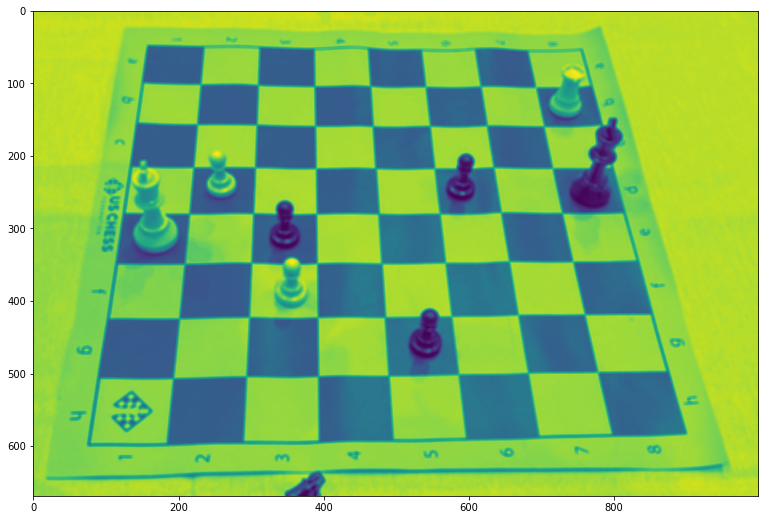

In [16]:
img, gray_blur = read_img(file_name)
plt.figure(figsize = (13,13))
plt.imshow(gray_blur)

### Canny edge detection

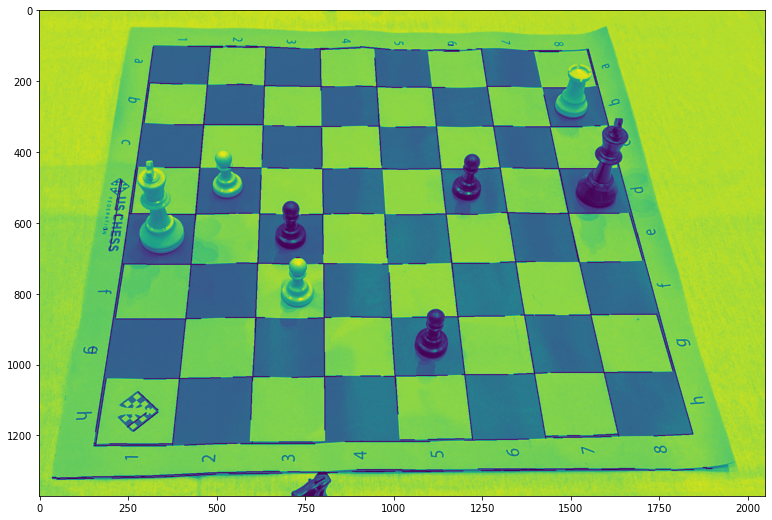

In [ ]:
import imageio
img = imageio.imread(str(file_name))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# remove noise
img_ = cv2.GaussianBlur(gray,(3,3),0)
edgesCanny = cv2.Canny(img_, 100,220)
lines_list =[]
lines = cv2.HoughLinesP(
            edgesCanny, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=80, # Min number of votes for valid line
            minLineLength=4, # Min allowed length of line
            maxLineGap=15 # Max allowed gap between line for joining them
            )
 
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(img_,(x1,y1),(x2,y2),(0,255,0),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
plt.figure(figsize = (13,13))
plt.imshow(img_)

0 255


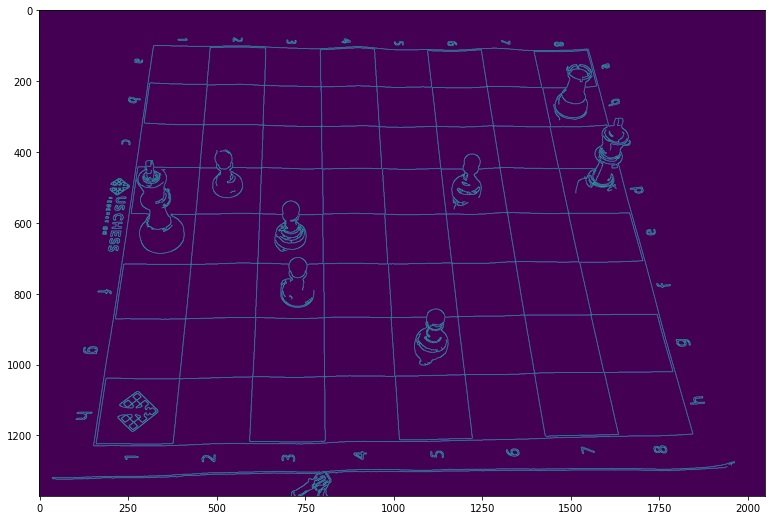

In [ ]:
img = cv2.imread(str(file_name), 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray, (3, 3))
    
# Canny edge detection
edges = auto_canny(gray)
plt.figure(figsize = (13,13))
plt.imshow(edges)

### Hough line detection

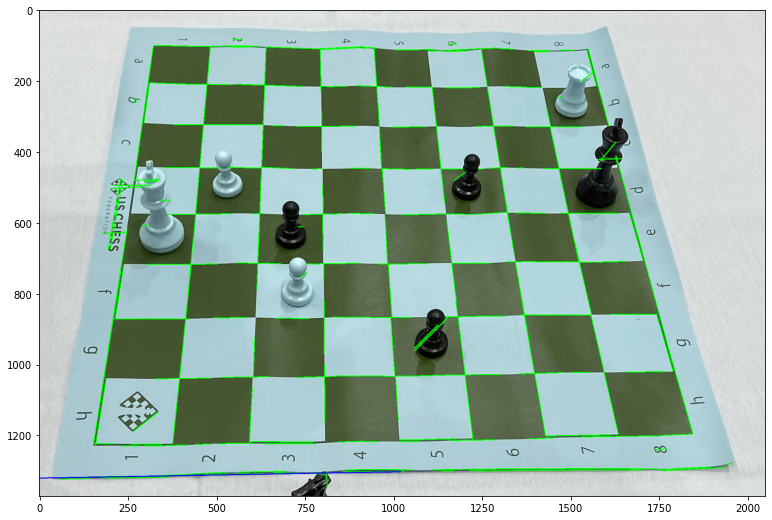

In [ ]:
# Hough line detection
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)


for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.figure(figsize = (13,13))
plt.imshow(img)

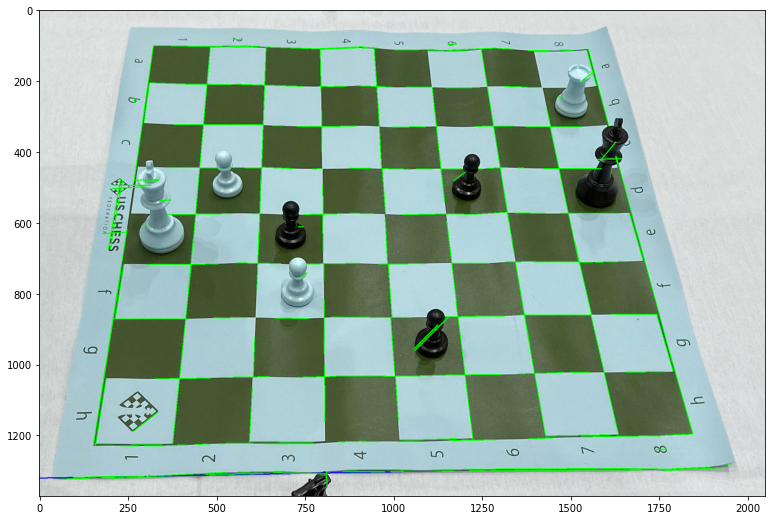

In [ ]:
lines_list =[]
lines = cv2.HoughLinesP(
            edges, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=80, # Min number of votes for valid line
            minLineLength=4, # Min allowed length of line
            maxLineGap=15 # Max allowed gap between line for joining them
            )
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
plt.figure(figsize = (13,13))
plt.imshow(img)

 ### Compute intersection points

points: (87, 2)


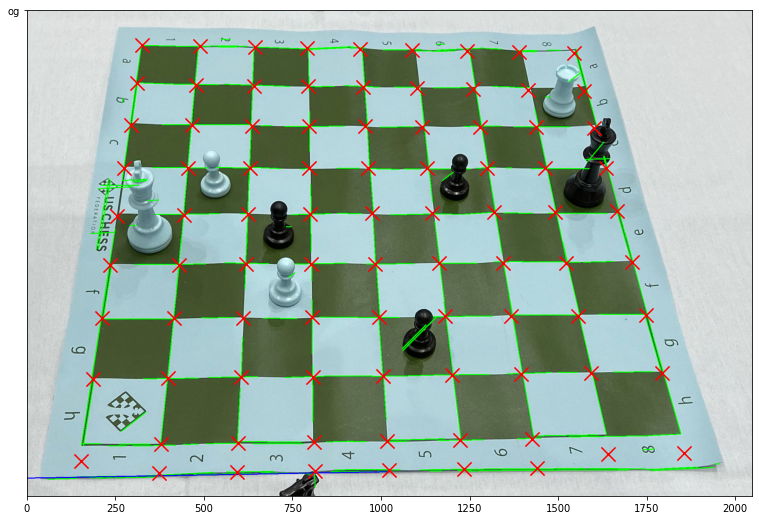

In [ ]:
# Compute intersection points
lines = np.reshape(lines, (-1, 2))
h, v = hor_vert_lines(lines)
points = intersections(h, v)

# Cluster intersection points
points = cluster(points)


print('points: ' + str(np.shape(points)))
pts = np.array(points)
plt.figure(figsize = (13,13))
plt.imshow(img)
plt.plot("og", markersize=10)  # og:shorthand for green circle
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)
plt.show()

### Find corners

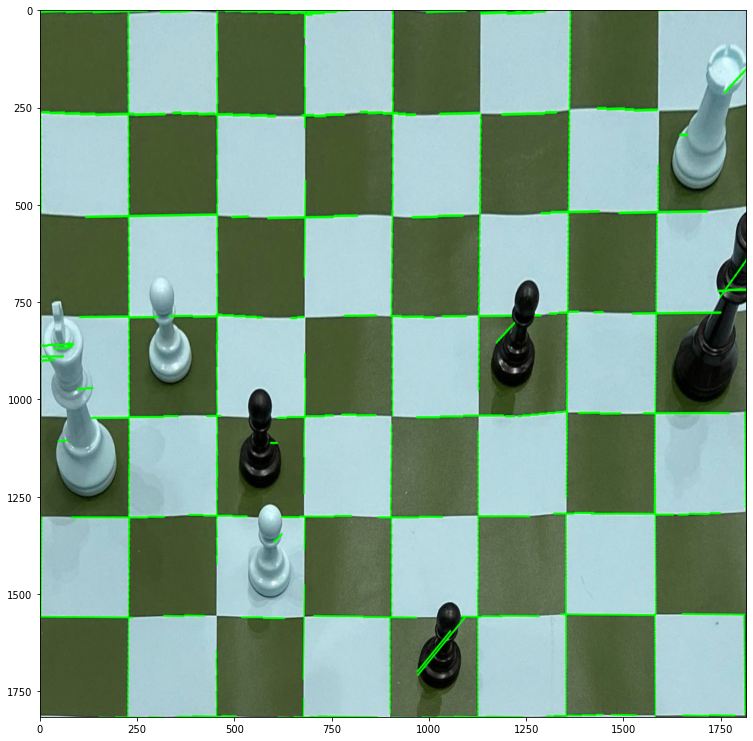

In [ ]:
# Find corners
img_shape = np.shape(img)
points = find_corners(points, (img_shape[1], img_shape[0]))
# Perspective transform
new_img = four_point_transform(img, points)

plt.figure(figsize = (13,13))
plt.imshow(new_img)


## Execute on all images 

In [12]:
# To be parameterize wit your path 
stre=str(train_img_filename_list[0])
print(stre[48:])

IMG_0299_JPG.rf.7d92f1ba0929b7fc5e77848b80148fc6.jpg


In [6]:
ii=0
j=len(train_img_filename_list)
for file_name in train_img_filename_list:
    boardFileName = str(file_name)
    print(boardFileName)
    #img, gray_blur = read_img(boardFileName)
    #boardFileName='drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/b7a8c7de4fe1382d69f58ac97e819b5c_jpg.rf.d3b1cfbb0c618d6afff8ea3b96c4d331.jpg'
    #print(boardFileName)
    board = find_board(boardFileName)
    if board is None:
        print("no board could be processed")
    else:
        print("OK - to proceed")
        squares = split_board(board)
        squares = np.array(squares)
        #print(squares.shape)
        #print(squares)
        for i in range(0,squares.shape[0]):
          data=squares[i]
          img = Image.fromarray(data, 'RGB')
          name=boardFileName[48:]
          img.save(path+'/train_squares/'+name+str(i)+'.jpg')
        print("Finished"+" "+str(ii)+" "+"of"+" "+str(j))
        ii=ii+1

drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/IMG_0299_JPG.rf.7d92f1ba0929b7fc5e77848b80148fc6.jpg
OK - to proceed
Finished 0 of 202
drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/b7a8c7de4fe1382d69f58ac97e819b5c_jpg.rf.d3b1cfbb0c618d6afff8ea3b96c4d331.jpg
OK - to proceed
Finished 1 of 202
drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/8de03901c64a80070048ead3fb0d32bd_jpg.rf.d4cd4d7336cee96c7c01731c6f3b81cd.jpg
OK - to proceed
Finished 2 of 202
drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/0b4ba28f0c759a11750a6430649b52e3_jpg.rf.c840c64b42f1edd63fd63024fed5ec8b.jpg
OK - to proceed
Finished 3 of 202
drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/3091c9b25d76e9cbd0af83ced9f354e5_jpg.rf.a96c979a388355dec7d4f832c0027f12.jpg
OK - to proceed
Finished 4 of 202
drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/8f84f1945fd993facc3368d13345f333_jpg.rf.3286223477d0f45d03a6a9854b7ff4a6.jpg
OK - to proceed
Finished 5 of 202
drive/My Drive/IMAGES_PROJET/Chess_Pieces/train/48e115dcbf1b3a67ca47a7

In [11]:
# To be parameterize wit your path 
stre_=str(test_img_filename_list[0])
print(stre_[47:])

a3863d0be6002c21b20ac88817b2c56f_jpg.rf.e421134b139d57e02e7df9468a35c1fb.jpg


In [12]:
ii=0
j=len(test_img_filename_list)
for file_name in test_img_filename_list:
    boardFileName = str(file_name)
    print(boardFileName)
    board = find_board(boardFileName)
    if board is None:
        print("no board could be processed")
    else:
        print("OK - to proceed")
        squares = split_board(board)
        squares = np.array(squares)
        #print(squares.shape)
        #print(squares)
        for i in range(0,squares.shape[0]):
          data=squares[i]
          img = Image.fromarray(data, 'RGB')
          name=boardFileName[47:]
          img.save(path+'/test_squares/'+name+str(i)+'.jpg')
        print("Finished"+" "+str(ii)+" "+"of"+" "+str(j))
        ii=ii+1

drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.e421134b139d57e02e7df9468a35c1fb.jpg
OK - to proceed
Finished 0 of 29
drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg
OK - to proceed
Finished 1 of 29
drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/b9402881fa580d0eb8b9b98845417550_jpg.rf.087d716cdfdd9cf2cb65b437af716d4d.jpg
OK - to proceed
Finished 2 of 29
drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/b526b661a33ff481231d1342aff2a266_jpg.rf.b63c85ea45c4e3a665915fddee8c76f9.jpg
OK - to proceed
Finished 3 of 29
drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/e0d38d159ad3a801d0304d7e275812cc_jpg.rf.fa0bb8160816a373df824349a24a11e7.jpg
OK - to proceed
Finished 4 of 29
drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/0b47311f426ff926578c9d738d683e76_jpg.rf.0b55f43ac16aa65c889558d8ea757072.jpg
OK - to proceed
Finished 5 of 29
drive/My Drive/IMAGES_PROJET/Chess_Pieces/test/685b860d412b91f5d4f7f9e643b84452_jp

In [17]:
# To be parameterize wit your path 
stre_=str(val_img_filename_list[0])
print(stre_[48:])

3aafc2d38807dddd1b43a54cb70f500d_jpg.rf.7a1acfea51aff18b554e96c49beafb78.jpg


In [18]:
ii=0
j=len(val_img_filename_list)
for file_name in val_img_filename_list:
    boardFileName = str(file_name)
    print(boardFileName)
    board = find_board(boardFileName)
    if board is None:
        print("no board could be processed")
    else:
        print("OK - to proceed")
        squares = split_board(board)
        squares = np.array(squares)
        #print(squares.shape)
        #print(squares)
        for i in range(0,squares.shape[0]):
          data=squares[i]
          img = Image.fromarray(data, 'RGB')
          name=boardFileName[48:]
          img.save(path+'/val_squares/'+name+str(i)+'.jpg')
        print("Finished"+" "+str(ii)+" "+"of"+" "+str(j))
        ii=ii+1

drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/3aafc2d38807dddd1b43a54cb70f500d_jpg.rf.7a1acfea51aff18b554e96c49beafb78.jpg
OK - to proceed
Finished 0 of 58
drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/d4f7caf01359b9a757c930140f746fad_jpg.rf.2b5cb1a63d242e69953a94e870bf8624.jpg
OK - to proceed
Finished 1 of 58
drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/ec418cafd39d7c5a69cc0642a08b2a08_jpg.rf.4d5b99fb671fd8cd28d64ed4f0293535.jpg
OK - to proceed
Finished 2 of 58
drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/d3b9309d00a2b671407b918ea867a935_jpg.rf.cbc8557646c90e2b2764e2746a672acd.jpg
OK - to proceed
Finished 3 of 58
drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/495019998442ddf85b59e387d4916cd3_jpg.rf.9d9d8ec43f8494e2bfe6603811f7b3de.jpg
OK - to proceed
Finished 4 of 58
drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/ca6484c259f286c5bdf1afefc868b753_jpg.rf.7aa1f1409074d5b0cbd19b20593cdcb5.jpg
OK - to proceed
Finished 5 of 58
drive/My Drive/IMAGES_PROJET/Chess_Pieces/valid/IMG_